In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import cv2
import heatmap
from PIL import Image

import sys
sys.path.append('../')
from cnn.commons import full_inference_e2e, inc_inference_e2e,adaptive_drilldown, show_heatmap_on_image, heatmap_f1_score
from cnn.vgg16 import VGG16
from cnn.resnet18 import ResNet18
from cnn.inception3 import Inception3

from cnn.vgg16_inc_v2 import IncrementalVGG16V2
from cnn.vgg16_inc_v1 import IncrementalVGG16V1
from cnn.resnet18_inc_v2 import IncrementalResNet18V2
from cnn.resnet18_inc_v1 import IncrementalResNet18V1
from cnn.inception3_inc_v2 import IncrementalInception3V2
from cnn.heatmap import Heatmapper

image_file_path = "../cnn/dog_resized.jpg"
interested_logit_index = 208

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
patch_size = 16
stride = 8

In [3]:
# torch.cuda.synchronize()
prev_time = time.time()
outputs_full = full_inference_e2e(Inception3, image_file_path, patch_size, stride, interested_logit_index, batch_size=64,
                                  x_size=299, y_size=299, image_size=299)
torch.cuda.synchronize()
full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

../cnn/commons.py:127: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  orig_image = Variable(loader(orig_image).unsqueeze(0), volatile=True)


Full Inference Time: 5.05172491074


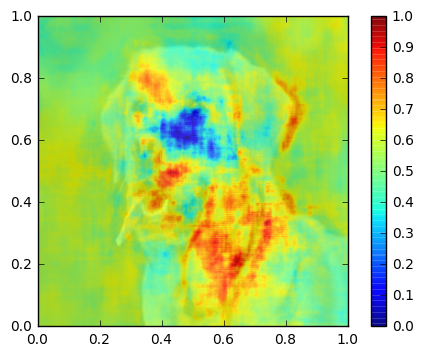

In [66]:
img = Image.open(image_file_path)

im1 = plt.imshow(img, extent=(0,1,0,1))
im2 = plt.imshow(x, cmap=plt.cm.jet, alpha=.8, interpolation='bilinear', extent=(0,1,0,1))
plt.colorbar()
plt.show()

In [7]:
np.fft.fft2(x).shape

(36, 36)

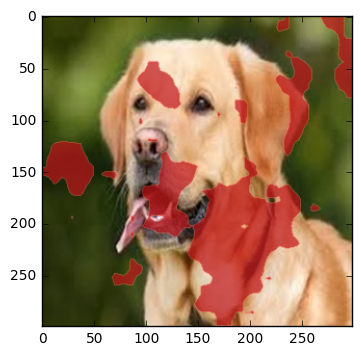

In [4]:
x = outputs_full
xmax, xmin = x.max(), x.min()
x = 1 - (x - xmin)/(xmax - xmin)

outputs_full_final = x
np.savetxt('temp', outputs_full_final)

show_heatmap_on_image(image_file_path, x, patch_size, stride, image_size=299)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False):
    torch.cuda.synchronize()
    if not adaptive:
        outputs_inc = inc_inference_e2e(IncrementalInception3V2, image_file_path, patch_size, stride, interested_logit_index,
                                  batch_size=64, beta=beta, image_size=299, x_size=299, y_size=299, num_batches=-1)
    else:
        outputs_inc = adaptive_drilldown(IncrementalInception3V2, image_file_path, patch_size, stride, interested_logit_index,
                                    batch_size=64, beta=beta, percentile=20, image_size=299, num_batches=-1)
    
    torch.cuda.synchronize()
    x = outputs_inc
    xmax, xmin = x.max(), x.min()
    x = 1 - (x - xmin)/(xmax - xmin)
    return x

### Path growth thresholding

In [ ]:
outputs_full_final = np.loadtxt('temp')
times = []
score = []

from PIL import Image
image = Image.open(image_file_path)

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
    prev_time = time.time()
    outputs_inc_final = inc_inference(beta, patch_size=patch_size, stride=stride)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    score.append(1-heatmap_f1_score(outputs_full_final, outputs_inc_final))

    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    show_heatmap_on_image(image_file_path, outputs_inc_final, patch_size, stride, image_size=299)

In [ ]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('1 - F1_Score')

### Adaptive drill-down

In [ ]:
outputs_full_final = np.loadtxt('temp')
times = []
score = []

for beta in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]:
    prev_time = time.time()
    outputs_inc_final = inc_inference(beta, patch_size=patch_size, stride=stride, adaptive=True)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    score.append(1-heatmap_f1_score(outputs_full_final, outputs_inc_final))
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    show_heatmap_on_image(image_file_path, outputs_inc_final, patch_size, stride, image_size=299)
    
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('1 - F1_Score')